# Food Security Risk
This notebook integrates NDVI, MapBiomas, and NASA nighttime lights data to create an index of risk to food security. 

In [ ]:
#Calculate exposure and vulnerability to create time series of food security risk index
import numpy as np
import pandas as pd
import rasterio
import os
#calculate exposure weights
def load_exposure_weights(csv_path):
    w = pd.read_csv(csv_path)
    lookup = {}
    for _, r in w.iterrows():
        lookup[(int(r.lulc), int(r.irrigated))] = float(r.exposure_weight)
    return lookup
#Create raster of exposure values based on LULC and irrigation values
def build_exposure_raster(lulc, irrig, weight_lookup):
    E = np.zeros_like(lulc, dtype="float32")
    irrig_bin = (irrig > 0).astype("int8")
    for (lulc_code, irr), w in weight_lookup.items():
        mask = (lulc == lulc_code) & (irrig_bin == irr)
        E[mask] = w
    return E
#Calculate vulnerability (nighttime lights)
def vulnerability_from_ntl(ntl, lo=5, hi=95):
    qlo, qhi = np.nanpercentile(ntl, [lo, hi])
    v = (ntl - qlo) / (qhi - qlo)
    v = np.clip(v, 0, 1)
    return (1 - v).astype("float32")
#directories
STACK_DIR = "stacked"
OUT_DIR = "risk_index"
WEIGHTS_CSV = "exposure_weights_zscore_based.csv"
os.makedirs(OUT_DIR, exist_ok=True)

years = range(2012, 2024)
weights = load_exposure_weights(WEIGHTS_CSV)
#loop through years
for y in years:
    fp = f"{STACK_DIR}/ndvi_viirs_lulc_{y}.tif"
    with rasterio.open(fp) as src:
        z     = src.read(1).astype("float32")
        ntl   = src.read(2).astype("float32")
        lulc  = src.read(3).astype("int16")
        irrig = src.read(4).astype("float32")
        profile = src.profile.copy()

    valid = (~np.isnan(z)) & (~np.isnan(ntl))

    # Hazard
    H = np.clip(-z / 3.0, 0, 1).astype("float32")

    # Exposure
    E = build_exposure_raster(lulc, irrig, weights)

    # Vulnerability
    V = vulnerability_from_ntl(ntl)
    #Risk index
    Risk = (H * E * V).astype("float32")
    Risk[~valid] = np.nan

    out_profile = profile.copy()
    out_profile.update(
        count=1,
        dtype="float32",
        nodata=np.nan,
        compress="lzw"
    )

    out_fp = f"{OUT_DIR}/risk_index_{y}.tif"

    with rasterio.open(out_fp, "w", **out_profile) as dst:
        dst.write(Risk, 1)
    #Assign risk categories based on FEWS-NET IPC
    bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.000001]
    RiskClass = np.digitize(Risk, bins=bins).astype("int16")
    RiskClass[~valid] = 0 

    class_profile = profile.copy()
    class_profile.update(
        count=1,
        dtype="int16",
        nodata=0,
        compress="lzw"
    )

    class_fp = f"{OUT_DIR}/risk_class_ipc_analog_{y}.tif"
    with rasterio.open(class_fp, "w", **class_profile) as dst:
        dst.write(RiskClass, 1)


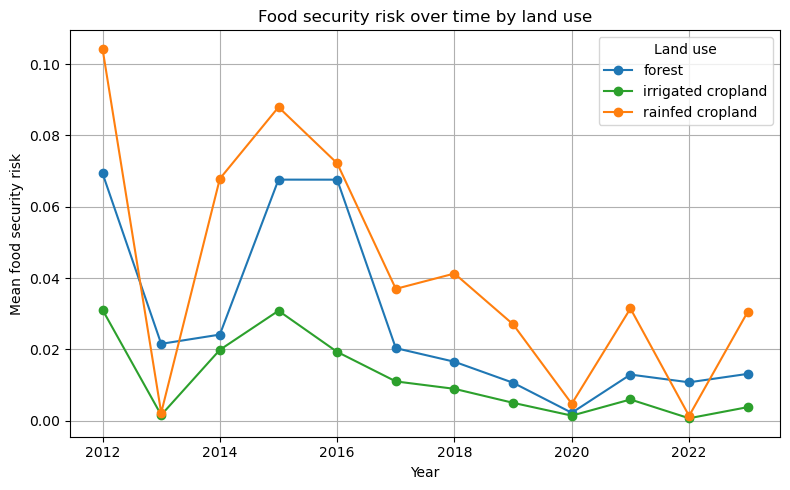

In [48]:
#Create time series of food security risk by LULC/irrigation
AG_CODES = [18, 19, 20, 35, 36, 39, 40, 41, 46, 47, 48]
FOREST_CODES = [1, 3, 6, 9]
import rasterio
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

STACK_DIR = "stacked"
RISK_DIR  = "risk_index"

years = range(2012, 2024)
records = []

for y in years:
    stack_fp = f"{STACK_DIR}/ndvi_viirs_lulc_{y}.tif"
    risk_fp  = f"{RISK_DIR}/risk_index_{y}.tif"

    with rasterio.open(stack_fp) as s, rasterio.open(risk_fp) as r:
        lulc  = s.read(3)
        irrig = s.read(4)
        risk  = r.read(1)

    valid = ~np.isnan(risk)

    # Forest
    forest = valid & np.isin(lulc, FOREST_CODES)

    # Cropland
    crop = valid & np.isin(lulc, AG_CODES)
    rainfed   = crop & (irrig == 0)
    irrigated = crop & (irrig > 0)

    records.extend([
        {"year": y, "landuse": "forest",
         "risk": np.nanmean(risk[forest])},

        {"year": y, "landuse": "rainfed_cropland",
         "risk": np.nanmean(risk[rainfed])},

        {"year": y, "landuse": "irrigated_cropland",
         "risk": np.nanmean(risk[irrigated])},
    ])

df_risk_ts = pd.DataFrame(records)

colors = {
    "forest": "tab:blue",
    "rainfed_cropland": "tab:orange",
    "irrigated_cropland": "tab:green"
}

plt.figure(figsize=(8,5))

for lu, g in df_risk_ts.groupby("landuse"):
    plt.plot(
        g.year,
        g.risk,
        marker="o",
        label=lu.replace("_", " "),
        color=colors[lu]
    )

plt.xlabel("Year")
plt.ylabel("Mean food security risk")
plt.title("Food security risk over time by land use")
plt.legend(title="Land use")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
#Create maps of food security risk by year
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio

def load_exposure_weights(csv_path):
    df = pd.read_csv(csv_path)
    lookup = {}
    for _, r in df.iterrows():
        lookup[(int(r.lulc), int(r.irrigated))] = float(r.exposure_weight)
    return lookup

weights = load_exposure_weights("exposure_weights_zscore_based.csv")

def build_exposure_raster(lulc, irrig, weight_lookup):
    E = np.zeros_like(lulc, dtype="float32")
    irrig_bin = (irrig > 0).astype("int8")

    for (lulc_code, irr), w in weight_lookup.items():
        mask = (lulc == lulc_code) & (irrig_bin == irr)
        E[mask] = w

    return E

def vulnerability_from_ntl(ntl, lo=5, hi=95):
    qlo, qhi = np.nanpercentile(ntl, [lo, hi])
    v = (ntl - qlo) / (qhi - qlo)
    v = np.clip(v, 0, 1)
    return (1 - v).astype("float32")

STACK_DIR = "stacked"
RISK_DIR  = "risk_index"
FIG_DIR   = "risk_maps_png"

os.makedirs(RISK_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

years = range(2012, 2024)

for y in years:
    stack_fp = f"{STACK_DIR}/ndvi_viirs_lulc_{y}.tif"
    if not os.path.exists(stack_fp):
        print(f"Missing {y}, skipping")
        continue

    with rasterio.open(stack_fp) as src:
        z     = src.read(1).astype("float32")
        ntl   = src.read(2).astype("float32")
        lulc  = src.read(3).astype("int16")
        irrig = src.read(4).astype("float32")
        profile = src.profile.copy()

    valid = (~np.isnan(z)) & (~np.isnan(ntl))

    # Hazard
    H = np.clip(-z / 3.0, 0, 1).astype("float32")

    # Exposure
    E = build_exposure_raster(lulc, irrig, weights)

    # Vulnerability
    V = vulnerability_from_ntl(ntl)

    # Risk index
    Risk = (H * E * V).astype("float32")
    Risk[~valid] = np.nan

    # Save raster
    out_profile = profile.copy()
    out_profile.update(count=1, dtype="float32", nodata=np.nan, compress="lzw")

    out_risk_fp = f"{RISK_DIR}/risk_index_{y}.tif"
    with rasterio.open(out_risk_fp, "w", **out_profile) as dst:
        dst.write(Risk, 1)

    # Plot map
    plt.figure(figsize=(7,6))
    cmap = plt.cm.RdYlGn.copy()
    cmap.set_bad("white")
    plt.imshow(Risk, vmin=0, vmax=1)
    plt.title(f"Food security risk – {y}")
    plt.axis("off")
    plt.colorbar(label="Risk (0–1)")
    plt.tight_layout()
    #Save map
    png_fp = f"{FIG_DIR}/risk_{y}.png"
    plt.savefig(png_fp, dpi=200)
    plt.close()
#Create movie
gif_fp = "food_security_risk_2012_2024.gif"

frames = []
for y in years:
    png_fp = f"{FIG_DIR}/risk_{y}.png"
    if os.path.exists(png_fp):
        frames.append(imageio.imread(png_fp))

imageio.mimsave(gif_fp, frames, duration=2)